In [63]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import os
import joblib

Читаем csv с другой папки

In [64]:
tr = pd.read_csv('../csv_file/train.csv', low_memory=False) 

In [65]:
vd = pd.read_csv('../csv_file/valid.csv', low_memory=False) 

Сразу убираем дубликаты

In [66]:
tr = tr.drop_duplicates(subset=["client_id"]) 


In [67]:
vd = vd.drop_duplicates(subset=["client_id"]) 


Пора проверить пропуски

In [68]:
tr_missing_fraction = tr.isnull().mean()
vd_missing_fraction = vd.isnull().mean()

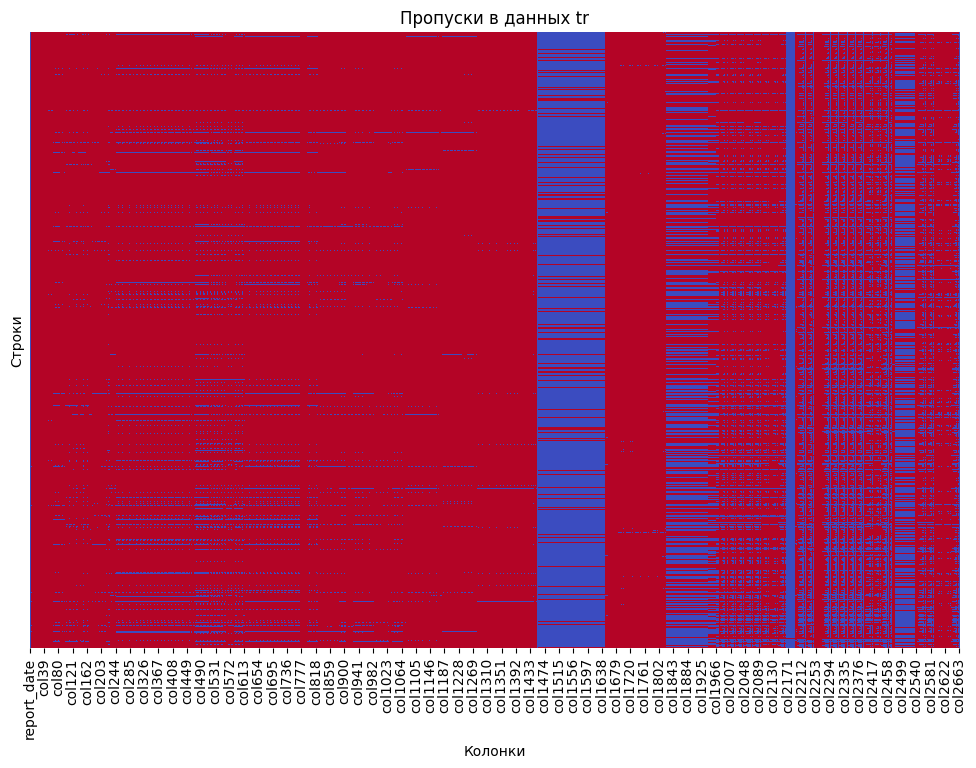

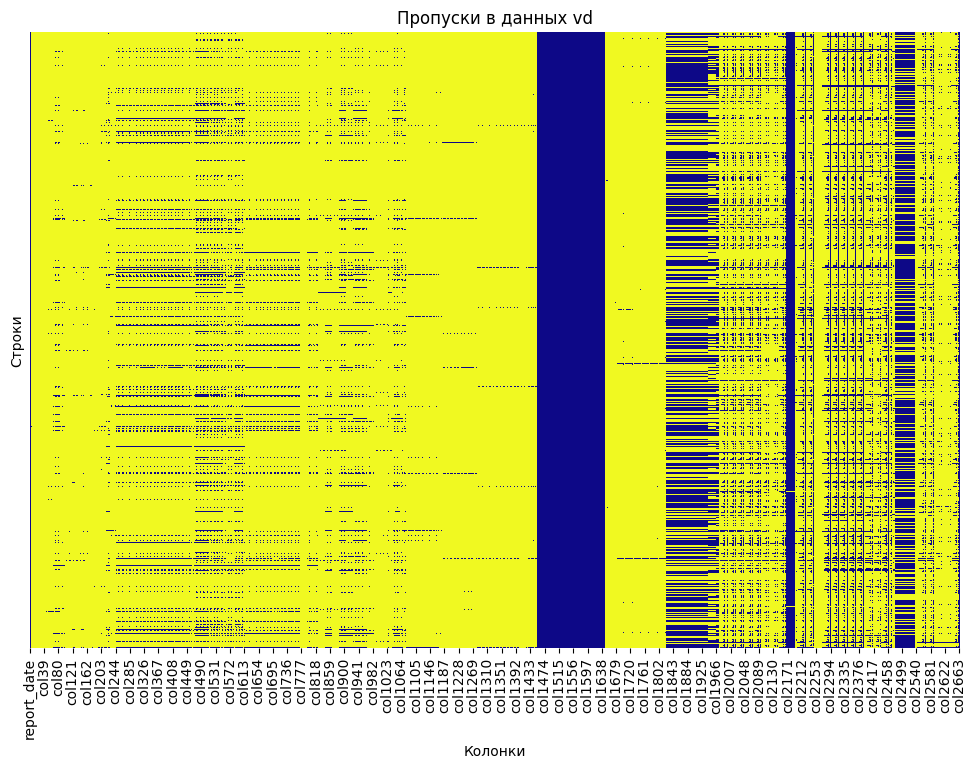

In [69]:
combined_missing_fraction = pd.concat([tr_missing_fraction, vd_missing_fraction], axis=1).max(axis=1)


plt.figure(figsize=(12, 8))
sns.heatmap(tr.isnull(), cbar=False, cmap="coolwarm", yticklabels=False)
plt.title("Пропуски в данных tr", fontsize=12)
plt.xlabel("Колонки")
plt.ylabel("Строки")
plt.show()


plt.figure(figsize=(12, 8))
sns.heatmap(vd.isnull(), cbar=False, cmap="plasma", yticklabels=False)
plt.title("Пропуски в данных vd", fontsize=12)
plt.xlabel("Колонки")
plt.ylabel("Строки")
plt.show()

Теперь удаляем пропуски

In [70]:
threshold = 0.75

tr_missing_fraction = tr.isnull().mean()
vd_missing_fraction = vd.isnull().mean()

combined_missing_fraction = pd.concat([tr_missing_fraction, vd_missing_fraction], axis=1).max(axis=1)

columns_to_drop = combined_missing_fraction[combined_missing_fraction > threshold].index

tr_cleaned = tr.drop(columns=columns_to_drop)
vd_cleaned = vd.drop(columns=columns_to_drop)

if sorted(tr_cleaned.columns) != sorted(vd_cleaned.columns):
    raise ValueError("Структуры tr и vd не совпадают после удаления колонок с пропусками!")
else:
    print("Структуры tr и vd совпадают после удаления колонок с пропусками.")


def has_mixed_types(column):
    types = set(column.dropna().map(type))  
    return float in types and str in types

#
mixed_type_columns_tr = [col for col in tr_cleaned.columns if has_mixed_types(tr_cleaned[col])]
mixed_type_columns_vd = [col for col in vd_cleaned.columns if has_mixed_types(vd_cleaned[col])]


columns_to_drop_mixed = set(mixed_type_columns_tr).union(mixed_type_columns_vd)
tr_cleaned = tr_cleaned.drop(columns=columns_to_drop_mixed)
vd_cleaned = vd_cleaned.drop(columns=columns_to_drop_mixed)


if sorted(tr_cleaned.columns) != sorted(vd_cleaned.columns):
    raise ValueError("Структуры tr и vd не совпадают после удаления колонок с разными типами данных!")
else:
    print("Структуры tr и vd теперь совпадают после удаления колонок с разными типами данных.")


tr_cleaned.to_csv('tr_cleaned.csv', index=False)
vd_cleaned.to_csv('vd_cleaned.csv', index=False)

print("Обработанные файлы сохранены как 'tr_cleaned.csv' и 'vd_cleaned.csv'.")



Структуры tr и vd совпадают после удаления колонок с пропусками.
Структуры tr и vd теперь совпадают после удаления колонок с разными типами данных.
Обработанные файлы сохранены как 'tr_cleaned.csv' и 'vd_cleaned.csv'.


In [71]:

for col in vd_cleaned.columns:
    if vd_cleaned[col].dtype in ['float64', 'int64']:  
        vd_cleaned[col].fillna(vd[col].median(), inplace=True)
    elif vd_cleaned[col].dtype == 'object':  
        vd_cleaned[col].fillna('unknown', inplace=True)

for col in tr_cleaned.columns:
    if tr_cleaned[col].dtype in ['float64', 'int64']:  
        tr_cleaned[col].fillna(tr[col].median(), inplace=True)
    elif tr_cleaned[col].dtype == 'object':   
        tr_cleaned[col].fillna('unknown', inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_9468\529153586.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  vd_cleaned[col].fillna('unknown', inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_9468\529153586.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

Иииии смотрим!

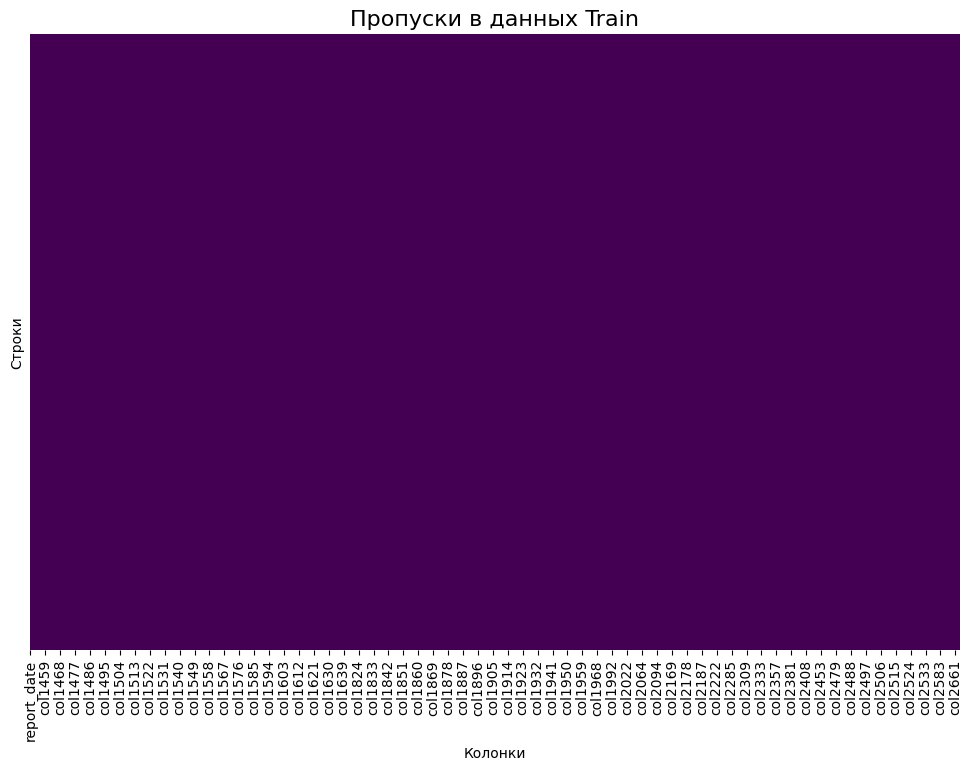

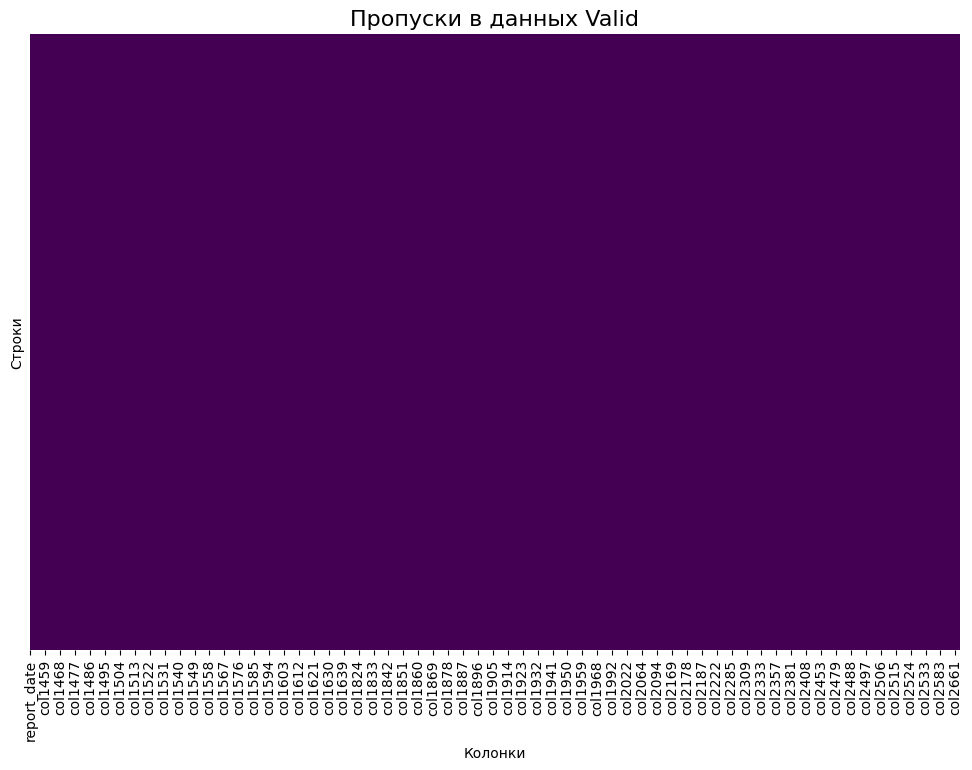

In [72]:
tr_missing_fraction = tr_cleaned.isnull().mean()
vd_missing_fraction = vd_cleaned.isnull().mean()


combined_missing_fraction = pd.concat([tr_missing_fraction, vd_missing_fraction], axis=1).max(axis=1)


plt.figure(figsize=(12, 8))
sns.heatmap(tr_cleaned.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Пропуски в данных Train", fontsize=16)
plt.xlabel("Колонки")
plt.ylabel("Строки")
plt.show()


plt.figure(figsize=(12, 8))
sns.heatmap(vd_cleaned.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Пропуски в данных Valid", fontsize=16)
plt.xlabel("Колонки")
plt.ylabel("Строки")
plt.show()

In [73]:
tr = tr.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [74]:
print(tr.columns)

Index(['report_date', 'client_id', 'target', 'col1', 'col2', 'col3', 'col4',
       'col5', 'col6', 'col7',
       ...
       'col2654', 'col2655', 'col2656', 'col2657', 'col2658', 'col2659',
       'col2660', 'col2661', 'col2662', 'col2663'],
      dtype='object', length=2666)


Пробная моделька

In [86]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


X = tr_cleaned.drop(columns=['client_id', 'target'])
y = tr_cleaned['target']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

X[categorical_features] = X[categorical_features].astype(str)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model.fit(X_train, y_train)

test_preds = model.predict_proba(X_test)[:, 1]
test_score = roc_auc_score(y_test, test_preds)

test_preds = np.pad(test_preds, (0, len(y_test) - len(test_preds)), mode='constant', constant_values=0)
print(f"ROC-AUC на тестовых данных: {test_score:.4f}")

if 'client_id' not in tr.columns:
    raise KeyError("Столбец 'client_id' отсутствует в данных!")

common_indices = X_test.index.intersection(tr.index)
missing_indices = X_test.index.difference(tr.index)

print(f"Общее количество индексов: {len(common_indices)}")
print(f"Количество отсутствующих индексов: {len(missing_indices)}")

X_test = X_test.loc[common_indices]

if len(test_preds) > len(common_indices):
    test_preds = test_preds[:len(common_indices)]

test_preds = pd.Series(test_preds, index=common_indices)

submission = pd.DataFrame({
    'client_id': tr.loc[common_indices, 'client_id'], 
    'score': test_preds  
})

submission.to_csv('submission_file.csv', index=False)
print("Результаты сохранены в submission_file.csv")






ROC-AUC на тестовых данных: 0.7692
Общее количество индексов: 619
Количество отсутствующих индексов: 345
Результаты сохранены в submission_file.csv


А теперь кривая

Размер y_test: 964
Размер test_preds: 964


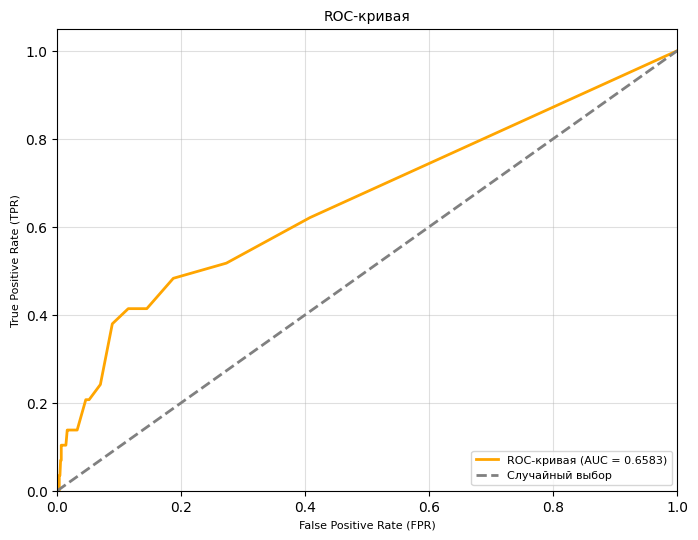

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

test_preds = np.pad(test_preds, (0, len(y_test) - len(test_preds)), mode='constant', constant_values=0)


print(f"Размер y_test: {len(y_test)}")
print(f"Размер test_preds: {len(test_preds)}")

if len(test_preds.shape) > 1:
    test_preds = test_preds[:, 1]  

fpr, tpr, thresholds = roc_curve(y_test, test_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC-кривая (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Случайный выбор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=8)
plt.ylabel('True Positive Rate (TPR)', fontsize=8)
plt.title('ROC-кривая', fontsize=10)
plt.legend(loc="lower right", fontsize=8)
plt.grid(alpha=0.4)
plt.show()